# Multi-File Linguistic Analysis - Dementia Dataset
This notebook processes JSON files from the dementia folder and performs linguistic analysis on character memory retellings across different ages. Each file contains a character's stories at different ages along with their deterioration onset age.

## Import Required Libraries

In [1]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy import stats

from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download required NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

True

## Load All JSON Files from Dementia Folder

In [2]:
def load_json_files_from_folder(folder_path):
    """Load all JSON files from a specified folder."""
    json_files = glob.glob(os.path.join(folder_path, "*.json"))
    all_data = []
    
    for file_path in json_files:
        try:
            with open(file_path, 'r', encoding='utf-8') as file:
                data = json.load(file)
                all_data.append(data)
                character_name = data.get('name', 'Unknown')
                start_deterioration_age = data.get('start_deterioration_age', 'Unknown')
                print(f"Loaded: {os.path.basename(file_path)} - Character: {character_name} - Start deterioration age: {start_deterioration_age}")
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    
    return all_data

# Load all JSON files from the dementia data folder
data_folder = "data_31_07/dementia2"
all_character_data = load_json_files_from_folder(data_folder)

print(f"\nLoaded {len(all_character_data)} character files.")

Loaded: jacob.json - Character: Jacob Stein - Start deterioration age: 66
Loaded: jessica.json - Character: Jessica Marie Holloway - Start deterioration age: 63
Loaded: james.json - Character: James Whitaker - Start deterioration age: 66
Loaded: anthony.json - Character: Anthony Samuel Reyes - Start deterioration age: 63
Loaded: keren.json - Character: Keren Aliza Hadar - Start deterioration age: 72
Loaded: george.json - Character: George Leonard - Start deterioration age: 66

Loaded 6 character files.


## Aggregate Retellings Across All Files

In [3]:
def aggregate_stories_with_years_before_diagnostic(all_character_data):
    """
    Combine all stories from all characters and calculate years before diagnostic.
    Each story becomes a data point with its years before diagnostic based on individual character's start_deterioration_age.
    """
    all_story_points = []
    
    for character_data in all_character_data:
        character_name = character_data.get('name', 'Unknown')
        stories = character_data.get('stories', [])
        deterioration_age = character_data.get('start_deterioration_age')
        
        if deterioration_age is None:
            print(f"Warning: No deterioration age found for {character_name}, skipping...")
            continue
        
        for story_data in stories:
            age = story_data.get('age')
            story = story_data.get('story', '')
            if age is not None and story:
                years_before_diagnostic = -(deterioration_age - age)
                all_story_points.append({
                    'character': character_name,
                    'age': age,
                    'deterioration_age': deterioration_age,
                    'years_before_diagnostic': years_before_diagnostic,
                    'story': story
                })
    
    return all_story_points

# Aggregate all stories with years before diagnostic calculation using individual deterioration ages
all_story_data = aggregate_stories_with_years_before_diagnostic(all_character_data)

# Display summary
print(f"Total story data points: {len(all_story_data)}")
if all_story_data:
    years_before_range = [point['years_before_diagnostic'] for point in all_story_data]
    print(f"Years before diagnostic range: {min(years_before_range)} to {max(years_before_range)}")

    # Show sample data points
    print(f"\nSample data points:")
    for i, point in enumerate(all_story_data[:5]):
        print(f"  {point['character']} - Age {point['age']} (deterioration starts at {point['deterioration_age']}) -> {point['years_before_diagnostic']} years before diagnostic")
        print(f"    Story length: {len(point['story'])} characters")

    # Show distribution by character
    character_counts = {}
    for point in all_story_data:
        char = point['character']
        character_counts[char] = character_counts.get(char, 0) + 1
    
    print(f"\nStory distribution by character:")
    for char, count in character_counts.items():
        # Get deterioration age from the original data
        deterioration_age = next((data['start_deterioration_age'] for data in all_character_data if data.get('name') == char), 'Unknown')
        print(f"  {char}: {count} stories (deterioration starts at age {deterioration_age})")
else:
    print("No story data found!")

Total story data points: 36
Years before diagnostic range: -12 to 12

Sample data points:
  Jacob Stein - Age 60 (deterioration starts at 66) -> -6 years before diagnostic
    Story length: 861 characters
  Jacob Stein - Age 63 (deterioration starts at 66) -> -3 years before diagnostic
    Story length: 792 characters
  Jacob Stein - Age 66 (deterioration starts at 66) -> 0 years before diagnostic
    Story length: 655 characters
  Jacob Stein - Age 69 (deterioration starts at 66) -> 3 years before diagnostic
    Story length: 694 characters
  Jacob Stein - Age 72 (deterioration starts at 66) -> 6 years before diagnostic
    Story length: 539 characters

Story distribution by character:
  Jacob Stein: 6 stories (deterioration starts at age 66)
  Jessica Marie Holloway: 6 stories (deterioration starts at age 63)
  James Whitaker: 6 stories (deterioration starts at age 66)
  Anthony Samuel Reyes: 6 stories (deterioration starts at age 63)
  Keren Aliza Hadar: 6 stories (deterioration sta

## Plotting Utility Function

In [4]:
def plot_scatter_with_regression(story_data, metric_function, label_y: str, title_suffix: str = ""):
    """Plot scatter plot of individual stories with linear regression trend line."""
    if not story_data:
        print(f"No data available for {label_y}")
        return
    
    # Calculate metric for each story
    x_values = []  # years before diagnostic
    y_values = []  # metric values
    characters = []
    
    for story_point in story_data:
        metric_value = metric_function(story_point['story'])
        x_values.append(story_point['years_before_diagnostic'])
        y_values.append(metric_value)
        characters.append(story_point['character'])
    
    if not x_values:
        print(f"No valid data points for {label_y}")
        return
    
    plt.figure(figsize=(12, 8))
    
    # Create scatter plot with different colors for each character
    unique_characters = list(set(characters))
    colors = plt.cm.tab10(range(len(unique_characters)))
    
    for i, character in enumerate(unique_characters):
        char_mask = [c == character for c in characters]
        char_x = [x for x, mask in zip(x_values, char_mask) if mask]
        char_y = [y for y, mask in zip(y_values, char_mask) if mask]
        
        plt.scatter(char_x, char_y, alpha=0.7, s=60, 
                   color=colors[i], label=character, edgecolors='black', linewidth=0.5)
    
    # Add linear regression trend line
    if len(x_values) > 1:
        z = np.polyfit(x_values, y_values, 1)
        p = np.poly1d(z)
        x_trend = np.linspace(min(x_values), max(x_values), 100)
        plt.plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2, label='Linear Trend')
        
        # Calculate and display correlation coefficient and p-value
        from scipy import stats
        correlation, p_value = stats.pearsonr(x_values, y_values)
        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
        
        plt.text(0.02, 0.98, f'Correlation: {correlation:.3f} ({significance})\np-value: {p_value:.4f}', 
                transform=plt.gca().transAxes, fontsize=10, 
                verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    plt.xlabel('Years Before Diagnostic', fontsize=12)
    plt.ylabel(f'{label_y}', fontsize=12)
    plt.title(f'{label_y} vs Years Before Diagnostic{title_suffix}', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def calculate_metric_for_all_stories(story_data, metric_function):
    """Calculate metric for each individual story."""
    story_metrics = []
    
    for story_point in story_data:
        metric_value = metric_function(story_point['story'])
        story_metrics.append({
            'character': story_point['character'],
            'age': story_point['age'],
            'years_before_diagnostic': story_point['years_before_diagnostic'],
            'metric_value': metric_value,
            'story': story_point['story']
        })
    
    return story_metrics

## Count Nouns by Age

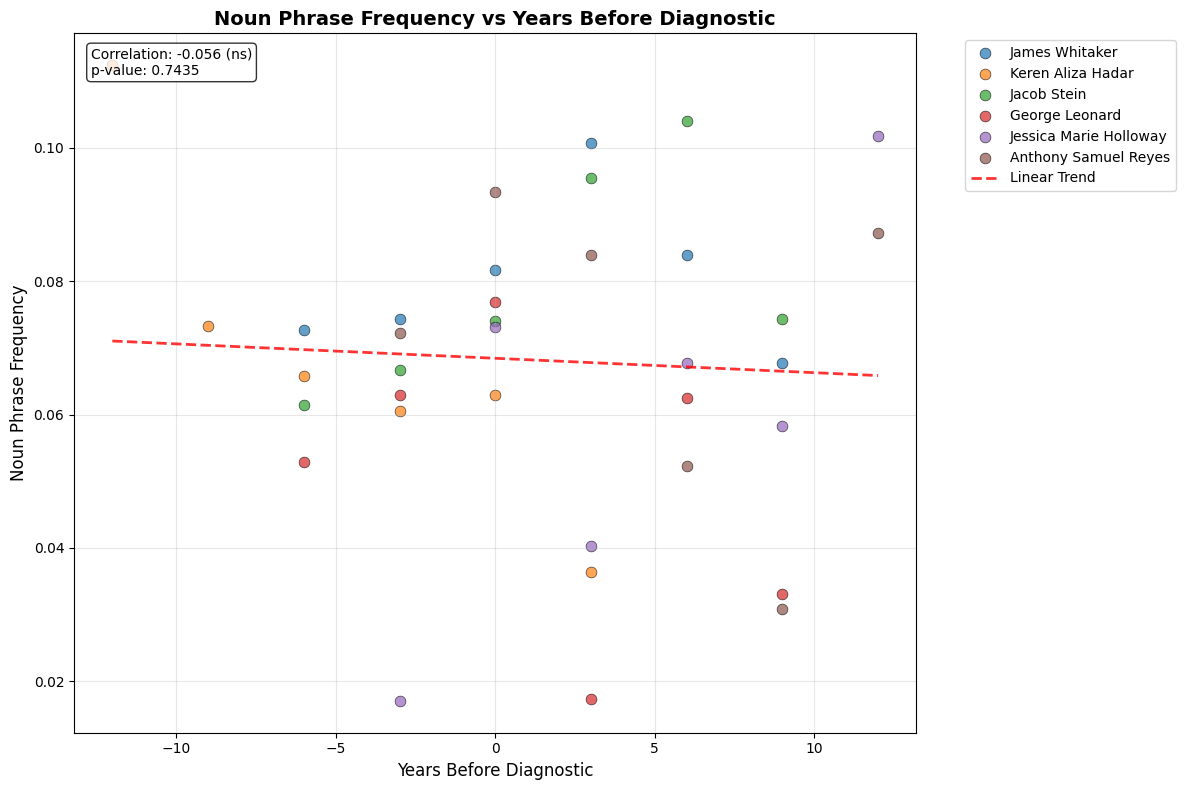

In [5]:
def nouns_freq_in_text(text):
    """Count the number of noun phrases in the given text."""
    blob = TextBlob(text)
    tokens = word_tokenize(text)
    if not tokens:
        return 0
    return len(blob.noun_phrases) / len(tokens)

# Plot noun frequency scatter plot
plot_scatter_with_regression(all_story_data, nouns_freq_in_text, "Noun Phrase Frequency")

## Calculate Hapax Legomena Frequency by Age

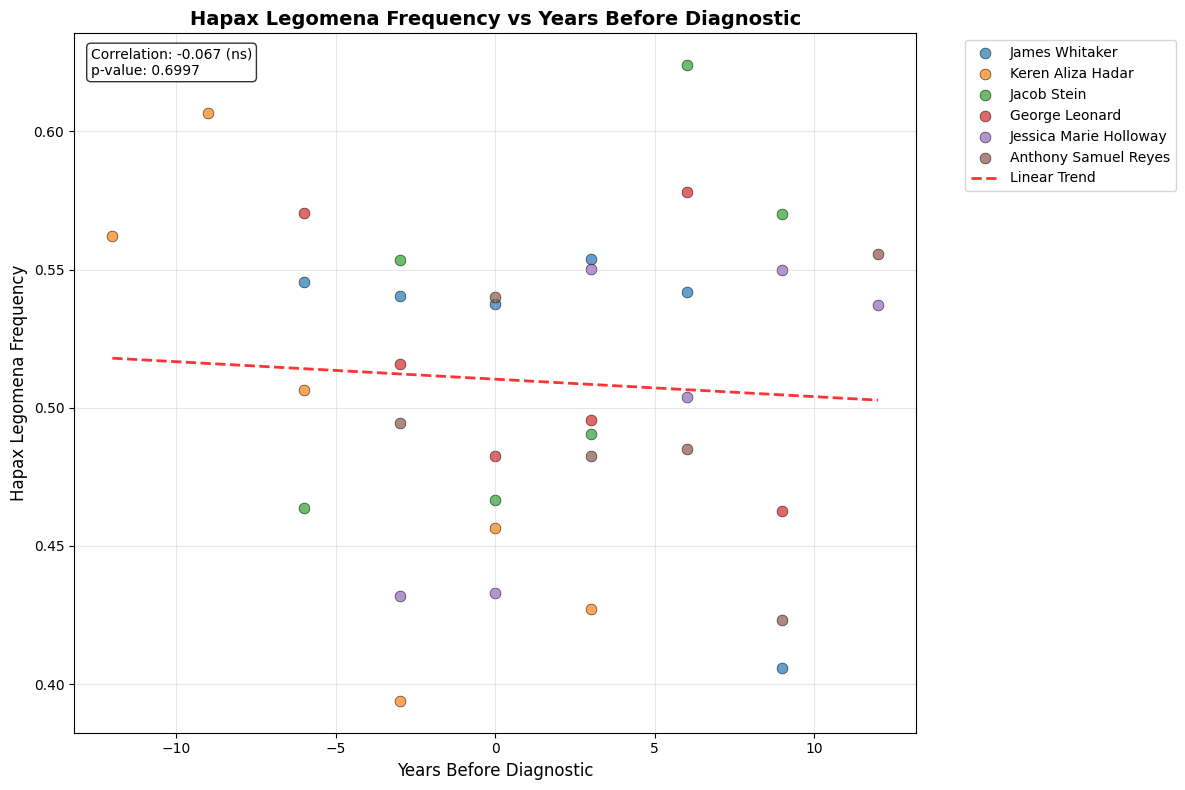

In [6]:
def word_used_once_frequency(text):
    """Calculate the frequency of words used only once in the text."""
    tokens = word_tokenize(text)
    if not tokens:
        return 0
    word_freq = nltk.FreqDist(tokens)
    once_count = sum(1 for _, count in word_freq.items() if count == 1)
    return once_count / len(tokens)

# Plot hapax legomena frequency scatter plot
plot_scatter_with_regression(all_story_data, word_used_once_frequency, "Hapax Legomena Frequency")

## Calculate Words Used Once or Twice Frequency by Age

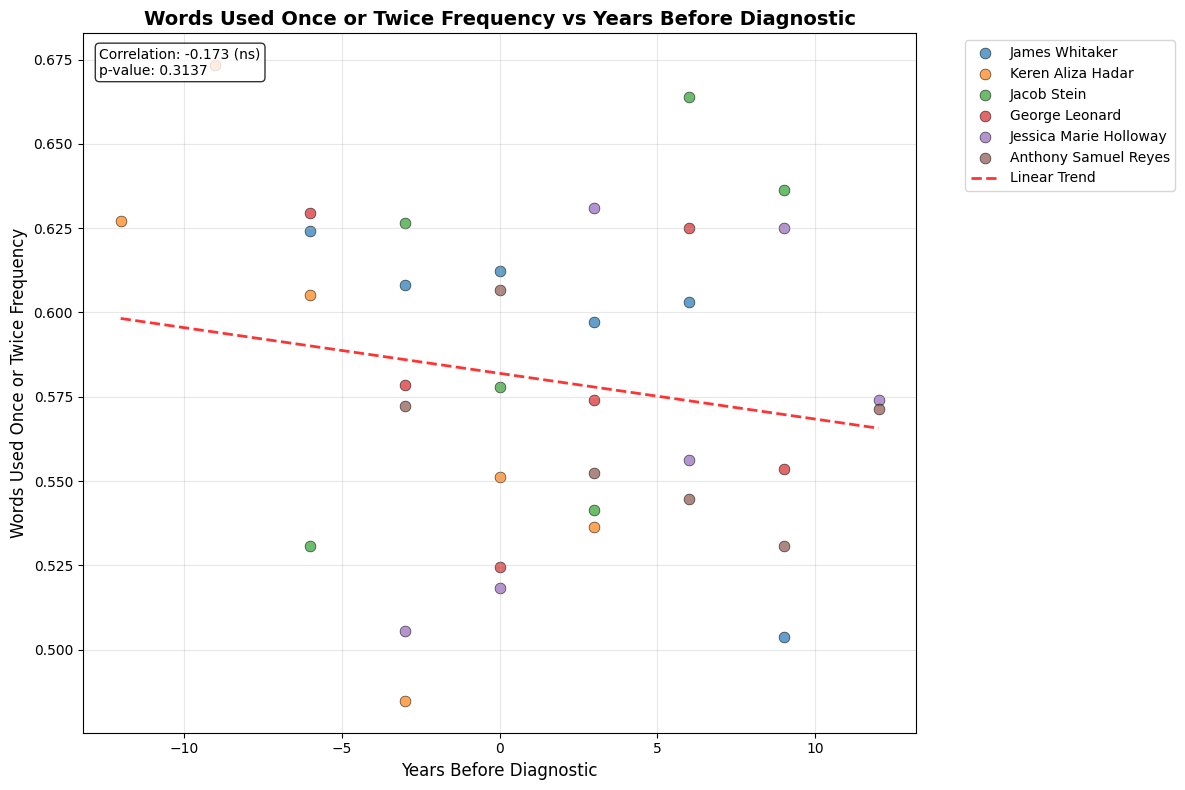

In [7]:
def word_used_once_or_twice_frequency(text):
    """Calculate the frequency of words used once or twice in the text."""
    tokens = word_tokenize(text)
    if not tokens:
        return 0
    word_freq = nltk.FreqDist(tokens)
    once_or_twice_count = sum(1 for _, count in word_freq.items() if count <= 2)
    return once_or_twice_count / len(tokens)

# Plot words used once or twice frequency scatter plot
plot_scatter_with_regression(all_story_data, word_used_once_or_twice_frequency, "Words Used Once or Twice Frequency")

## Calculate Brunet Index by Age

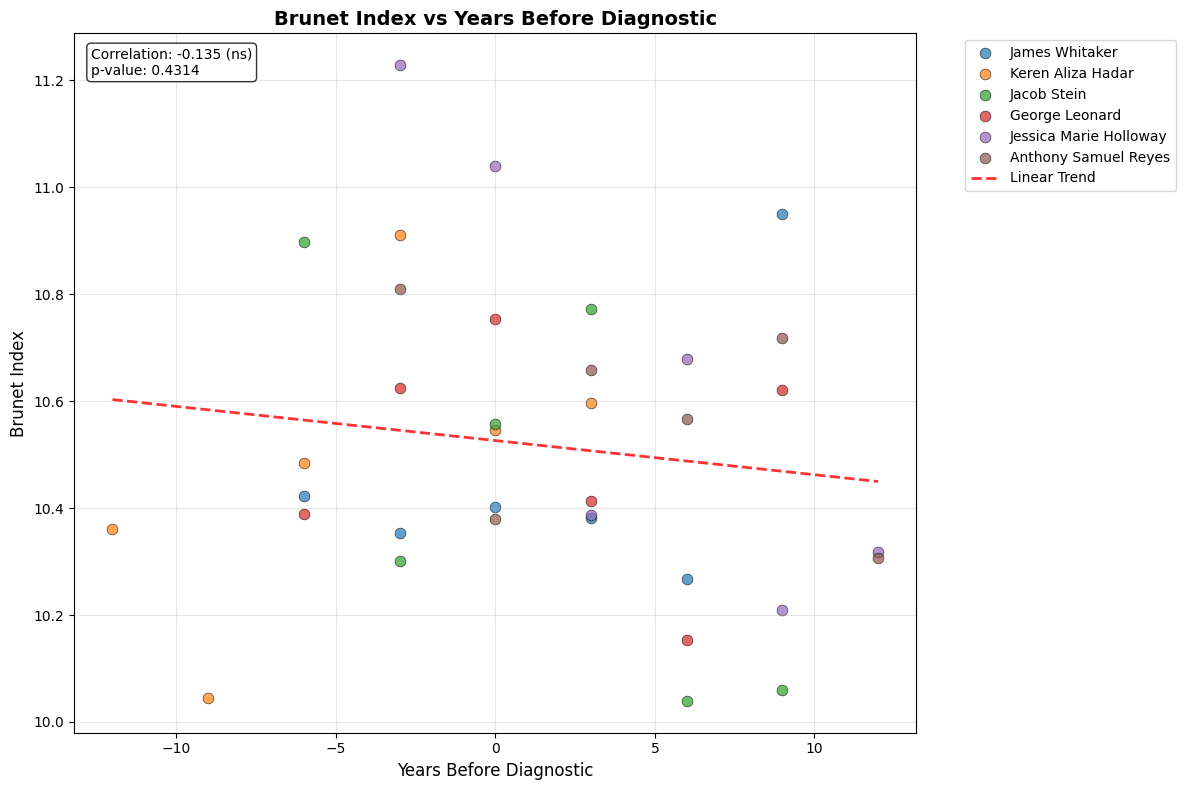

In [8]:
def brunet_index(text, alpha=-0.165):
    """Calculate the Brunet index for the text."""
    tokens = word_tokenize(text)
    if not tokens:
        return 0
    word_freq = nltk.FreqDist(tokens)
    unique_words = len(word_freq)
    tokens_count = len(tokens)
    if unique_words == 0 or tokens_count == 0:
        return 0
    return tokens_count ** (unique_words ** alpha)

# Plot Brunet index scatter plot
plot_scatter_with_regression(all_story_data, brunet_index, "Brunet Index")

## Calculate Type-Token Ratio by Age

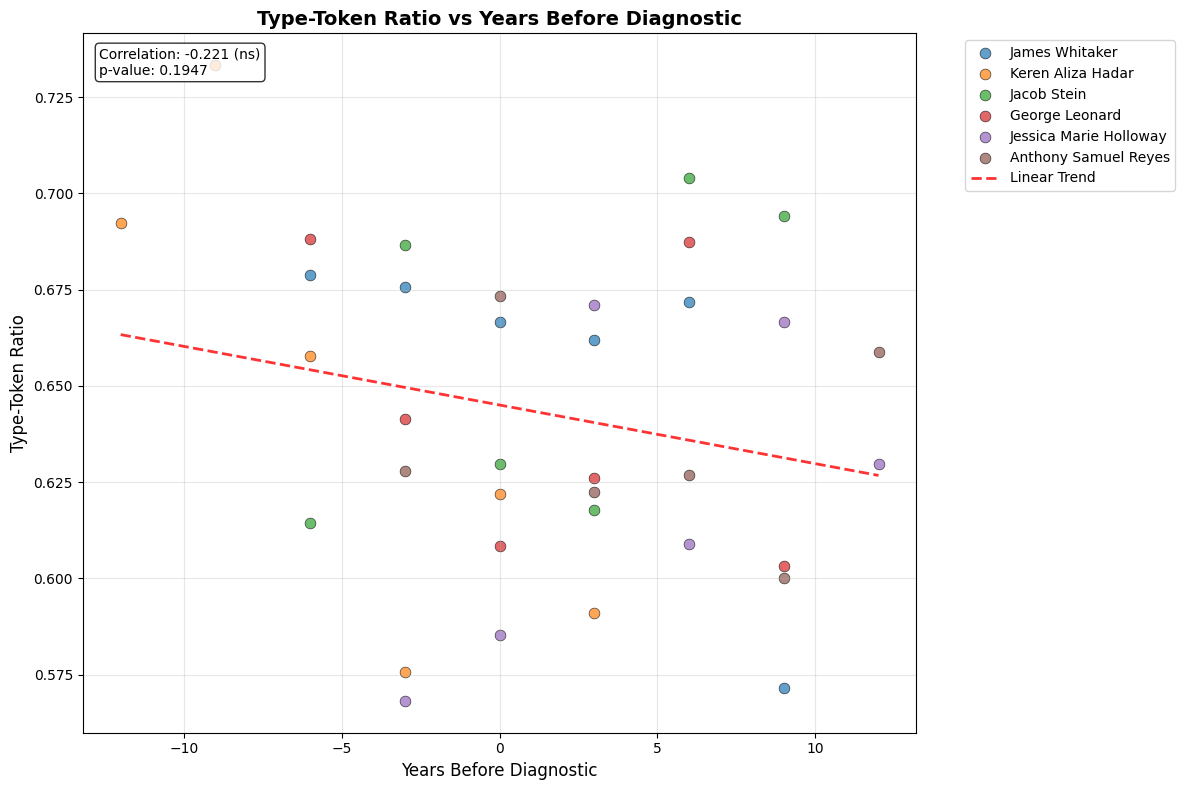

In [9]:
def token_type_ratio(text):
    """Calculate the type-token ratio for the text."""
    tokens = word_tokenize(text)
    if not tokens:
        return 0
    word_freq = nltk.FreqDist(tokens)
    unique_words = len(word_freq)
    tokens_count = len(tokens)
    return unique_words / tokens_count if tokens_count > 0 else 0

# Plot type-token ratio scatter plot
plot_scatter_with_regression(all_story_data, token_type_ratio, "Type-Token Ratio")

## Calculate Adposition Frequency by Age

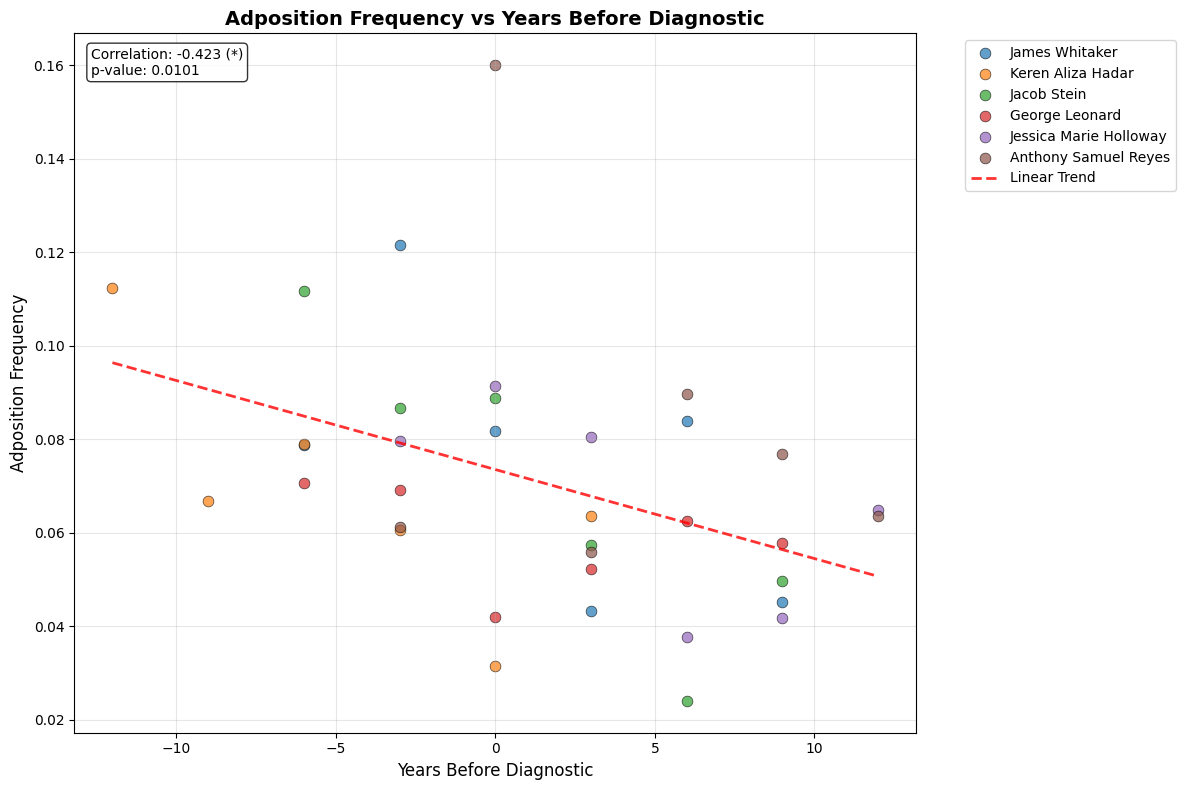

In [10]:
def adposition_frequency(text):
    """Calculate the frequency of adpositions in the text."""
    tokens = word_tokenize(text)
    if not tokens:
        return 0
    words_and_tags = nltk.pos_tag(tokens)
    adpositions_count = sum(1 for _, tag in words_and_tags if tag == "IN")
    return adpositions_count / len(tokens)

# Plot adposition frequency scatter plot
plot_scatter_with_regression(all_story_data, adposition_frequency, "Adposition Frequency")

## Calculate Unigram and Bigram Repetitions by Age

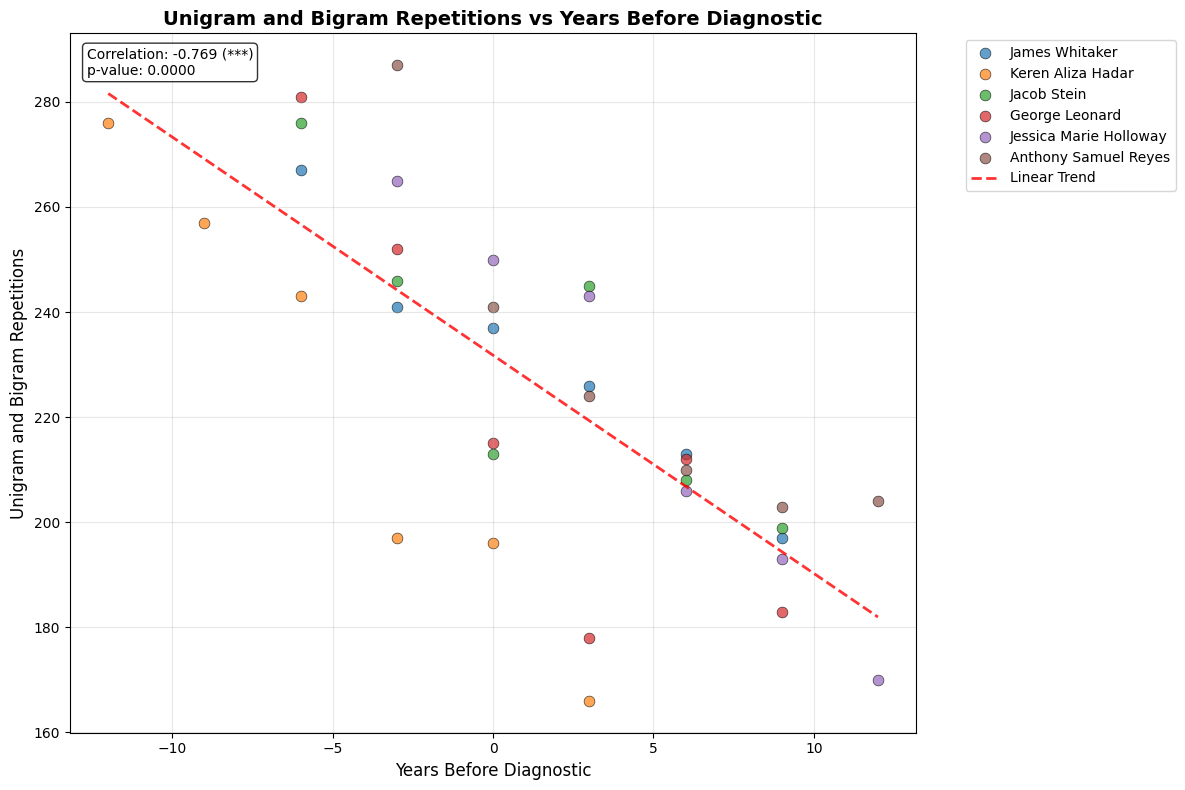

In [11]:
def uni_and_bi_grams_repetitions(text):
    """Calculate the number of unique unigrams and bigrams in the text."""
    tokens = word_tokenize(text)
    if not tokens:
        return 0
    unigrams = nltk.FreqDist(tokens)
    bigrams = nltk.FreqDist(nltk.bigrams(tokens))
    return len(unigrams) + len(bigrams)

# Plot unigram and bigram repetitions scatter plot
plot_scatter_with_regression(all_story_data, uni_and_bi_grams_repetitions, "Unigram and Bigram Repetitions")

## Load Word Frequency Data (CSV)

In [12]:
def load_csv(file_path):
    """Load a CSV file and return its content."""
    return pd.read_csv(file_path)

# Load word frequency data
try:
    subtl_and_zipf_df = load_csv('subtl_and_zipf.csv')
    # Filter relevant columns
    subtl_and_zipf_df = subtl_and_zipf_df[['Word','FREQcount', 'SUBTLWF', 'Zipf-value']]
    print("Successfully loaded word frequency data.")
    print(f"Shape: {subtl_and_zipf_df.shape}")
    print(subtl_and_zipf_df.head())
except FileNotFoundError:
    print("Warning: subtl_and_zipf.csv not found. Skipping frequency analysis.")
    subtl_and_zipf_df = None

Successfully loaded word frequency data.
Shape: (74286, 4)
    Word  FREQcount   SUBTLWF  Zipf-value
0      a    1041179  20415.27    7.309360
1     aa         87      1.71    3.236317
2    aaa         25      0.49    2.706807
3    aah       2688     52.71    4.721425
4  aahed          1      0.02    1.592864


## Calculate SUBTLEX Frequency by Age

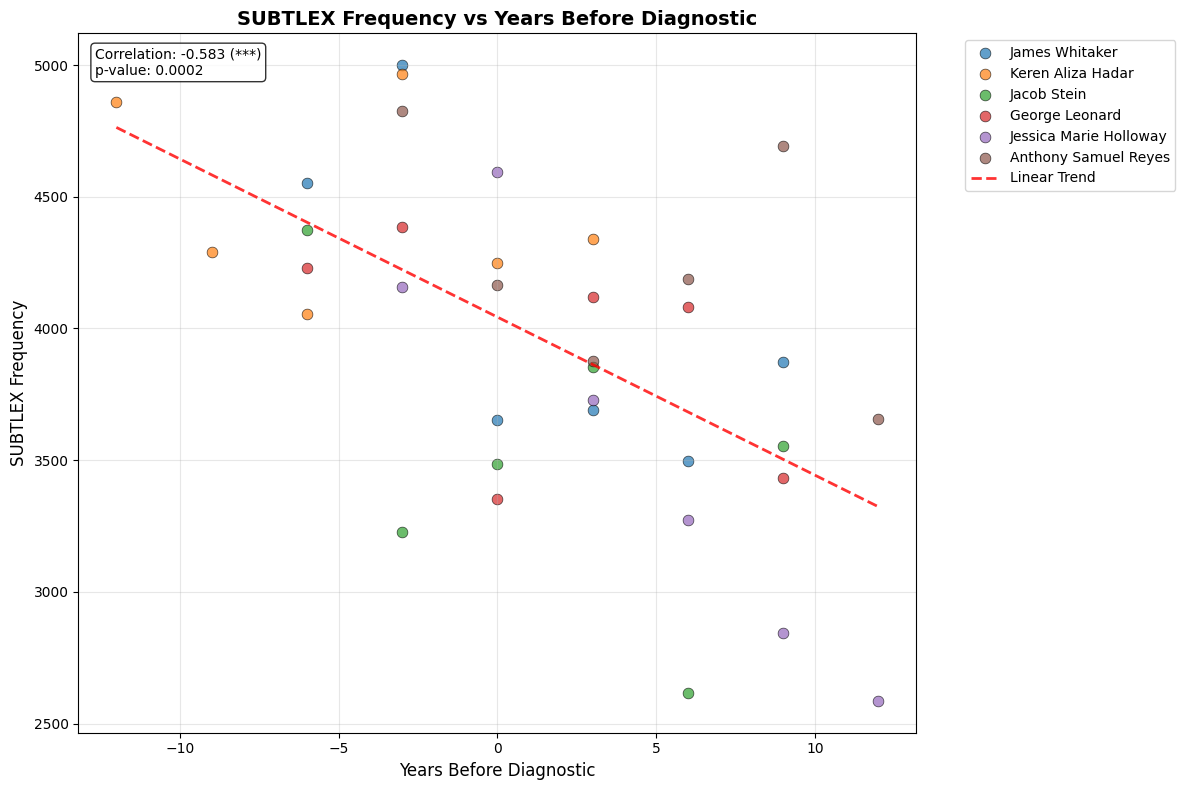

In [13]:
def word_freq_subtl(text, corpus_data):
    """Calculate the frequency of words in the text based on SUBTLEXus data."""
    if corpus_data is None:
        return 0
    
    tokens = word_tokenize(text)
    if not tokens:
        return 0
    
    word_freq = nltk.FreqDist(tokens)
    total_freq = sum(word_freq.values())
    
    subtl_freq = 0
    for word, freq in word_freq.items():
        word_lower = word.lower()
        matching_rows = corpus_data[corpus_data['Word'] == word_lower]
        if not matching_rows.empty:
            subtl_value = matching_rows['SUBTLWF'].values[0]
            subtl_freq += freq * subtl_value
    
    return subtl_freq / total_freq if total_freq > 0 else 0

# Plot SUBTLEX frequency scatter plot
if subtl_and_zipf_df is not None:
    def subtl_metric(text):
        return word_freq_subtl(text, subtl_and_zipf_df)
    
    plot_scatter_with_regression(all_story_data, subtl_metric, "SUBTLEX Frequency")
else:
    print("Skipping SUBTLEX frequency analysis due to missing data.")

## Calculate Zipf Frequency by Age

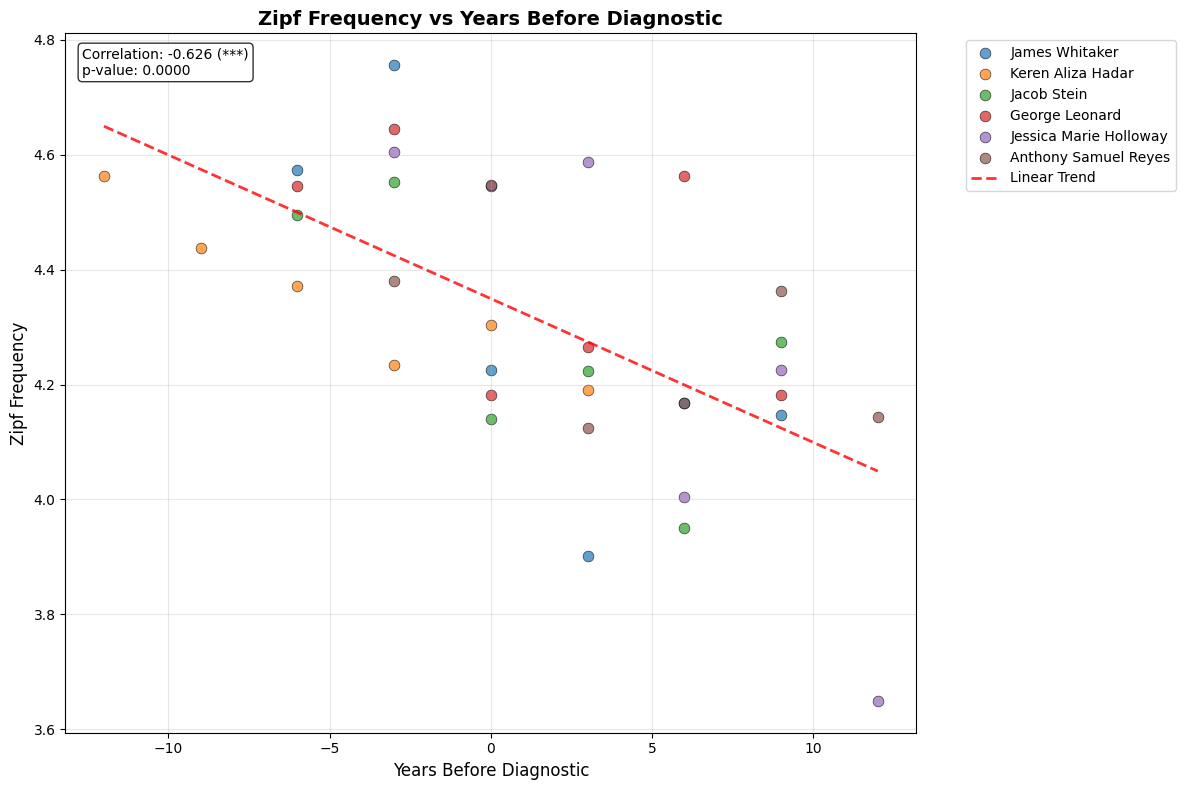

In [14]:
def word_freq_zipf(text, corpus_data):
    """Calculate the frequency of words in the text based on Zipf data."""
    if corpus_data is None:
        return 0
    
    tokens = word_tokenize(text)
    if not tokens:
        return 0
    
    word_freq = nltk.FreqDist(tokens)
    total_freq = sum(word_freq.values())
    
    zipf_freq = 0
    for word, freq in word_freq.items():
        word_lower = word.lower()
        matching_rows = corpus_data[corpus_data['Word'] == word_lower]
        if not matching_rows.empty:
            zipf_value = matching_rows['Zipf-value'].values[0]
            zipf_freq += freq * zipf_value
    
    return zipf_freq / total_freq if total_freq > 0 else 0

# Plot Zipf frequency scatter plot
if subtl_and_zipf_df is not None:
    def zipf_metric(text):
        return word_freq_zipf(text, subtl_and_zipf_df)
    
    plot_scatter_with_regression(all_story_data, zipf_metric, "Zipf Frequency")
else:
    print("Skipping Zipf frequency analysis due to missing data.")

## Comprehensive Visualization - All Metrics

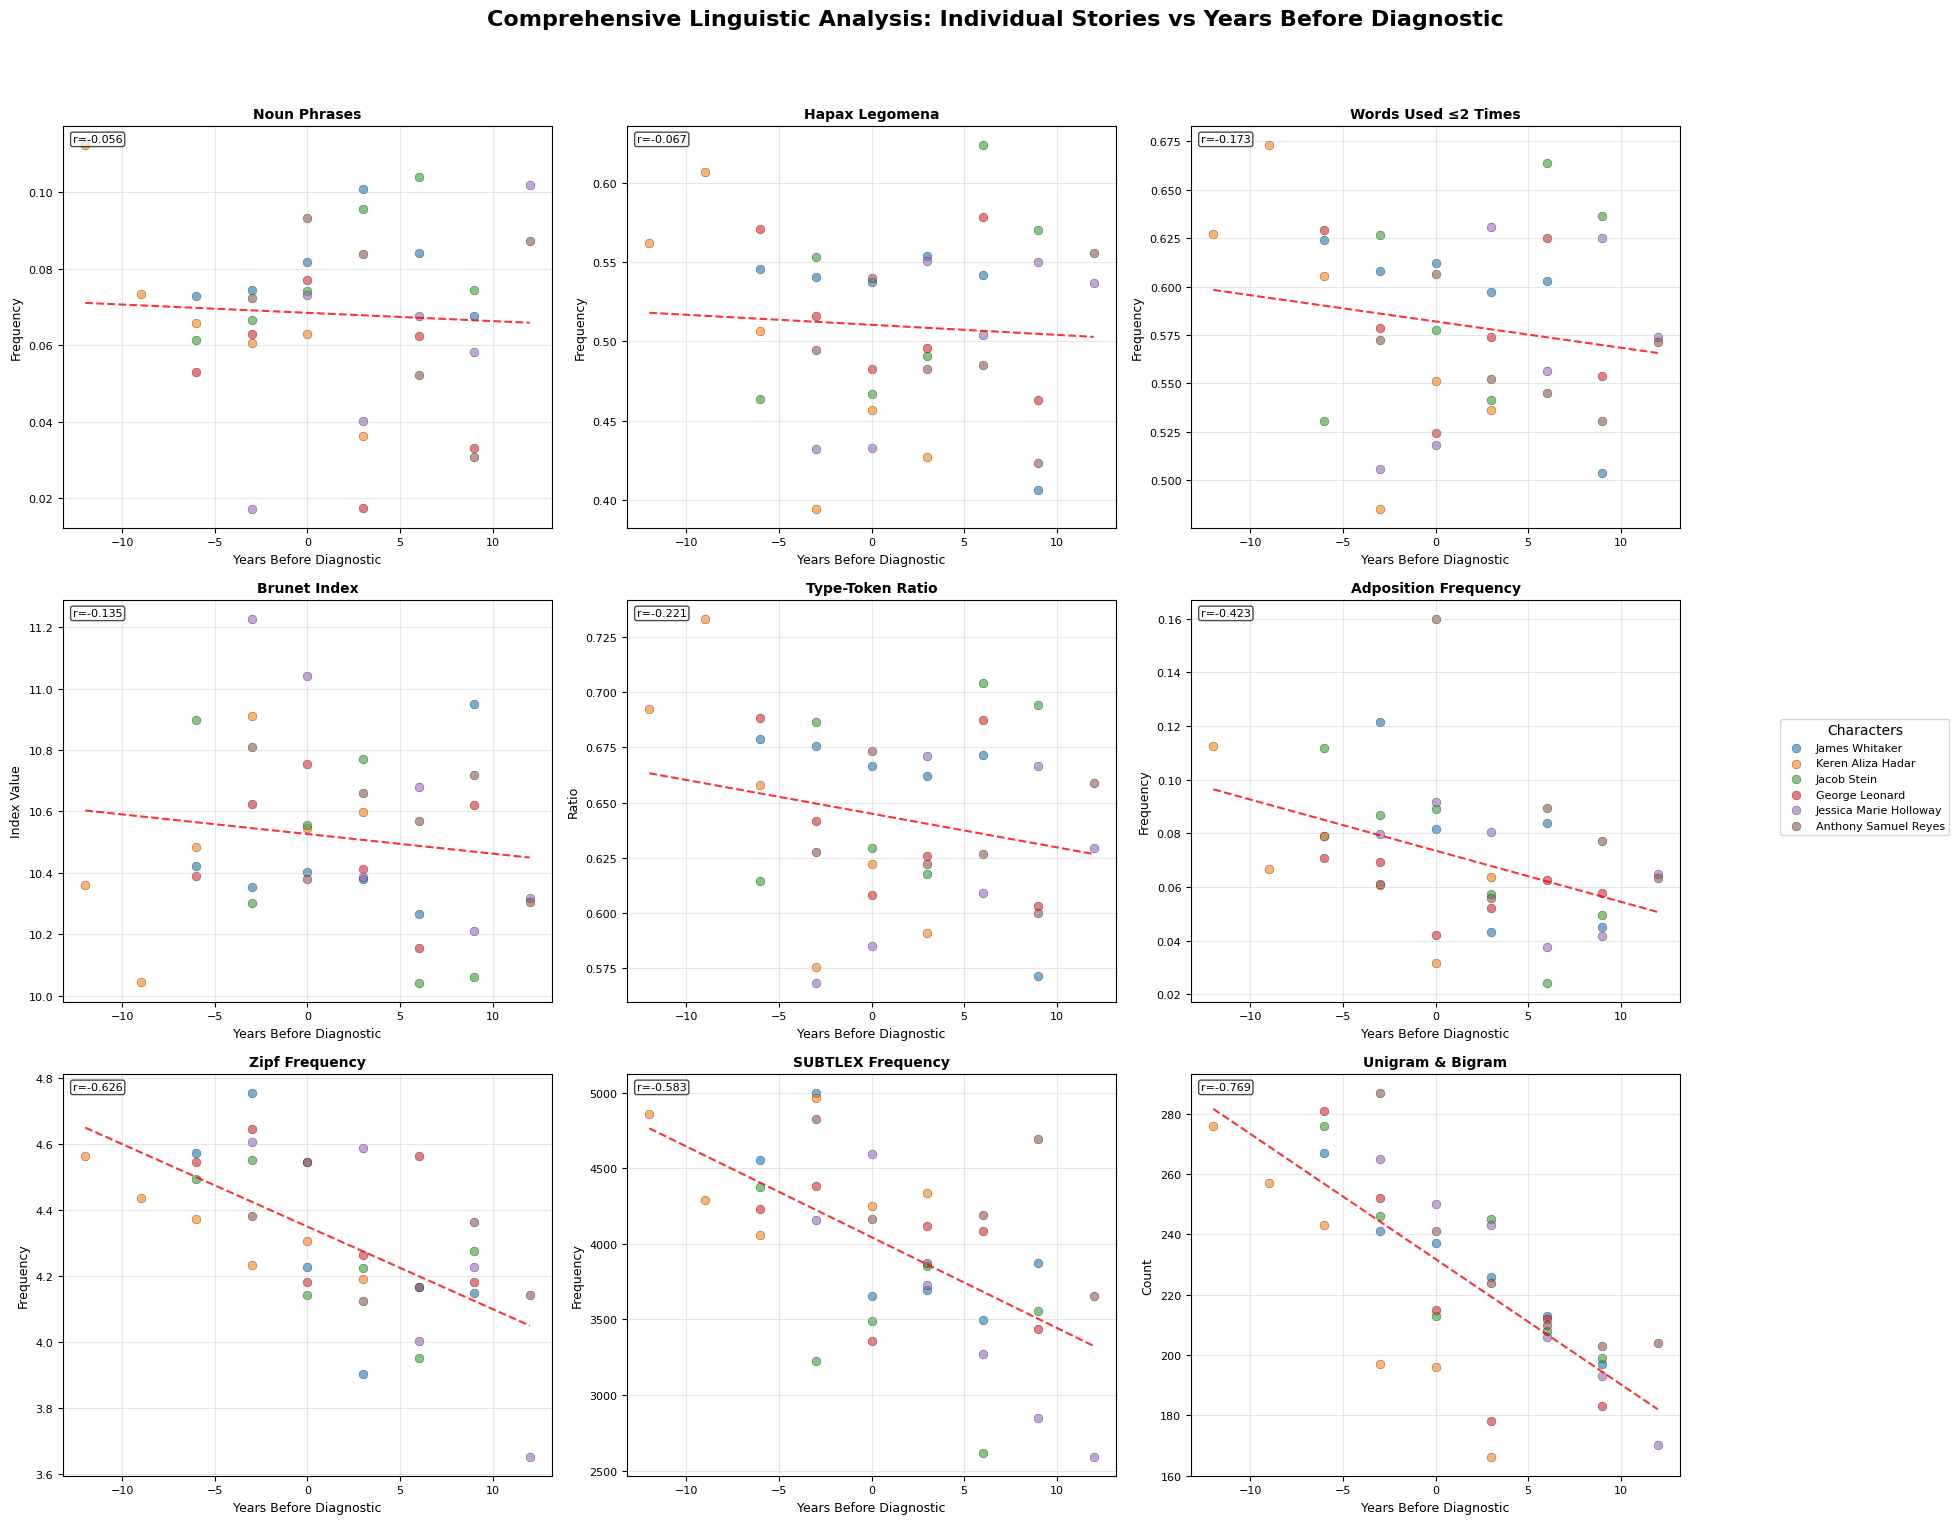

In [15]:
def create_comprehensive_scatter_plot():
    """Create a comprehensive 3x3 subplot showing all linguistic metrics as scatter plots."""
    
    # Prepare the metric functions
    metric_functions = [
        (nouns_freq_in_text, "Noun Phrases", "Frequency"),
        (word_used_once_frequency, "Hapax Legomena", "Frequency"),
        (word_used_once_or_twice_frequency, "Words Used ≤2 Times", "Frequency"),
        (brunet_index, "Brunet Index", "Index Value"),
        (token_type_ratio, "Type-Token Ratio", "Ratio"),
        (adposition_frequency, "Adposition Frequency", "Frequency"),
        (uni_and_bi_grams_repetitions, "Unigram & Bigram", "Count"),
    ]
    
    # Add frequency metrics if available
    if subtl_and_zipf_df is not None:
        def zipf_metric(text):
            return word_freq_zipf(text, subtl_and_zipf_df)
        def subtl_metric(text):
            return word_freq_subtl(text, subtl_and_zipf_df)
        
        uni_gram_and_bigram = metric_functions[-1]
        metric_functions[-1] = (zipf_metric, "Zipf Frequency", "Frequency")
        metric_functions.append((subtl_metric, "SUBTLEX Frequency", "Frequency"))
        metric_functions.append(uni_gram_and_bigram)
    
    # Create the subplot
    fig, axes = plt.subplots(3, 3, figsize=(20, 16))
    fig.suptitle('Comprehensive Linguistic Analysis: Individual Stories vs Years Before Diagnostic', fontsize=16, fontweight='bold')
    
    # Get unique characters and colors
    all_characters = list(set(point['character'] for point in all_story_data))
    colors = plt.cm.tab10(range(len(all_characters)))
    character_colors = dict(zip(all_characters, colors))
    
    # Plot each metric
    for i, (metric_function, title, ylabel) in enumerate(metric_functions):
        row = i // 3
        col = i % 3
        ax = axes[row, col]
        
        # Calculate metric for all stories
        x_values = []  # years before diagnostic
        y_values = []  # metric values
        characters = []
        
        for story_point in all_story_data:
            try:
                metric_value = metric_function(story_point['story'])
                x_values.append(story_point['years_before_diagnostic'])
                y_values.append(metric_value)
                characters.append(story_point['character'])
            except:
                continue  # Skip if metric calculation fails
        
        if x_values:
            # Create scatter plot with character-specific colors
            for character in all_characters:
                char_mask = [c == character for c in characters]
                char_x = [x for x, mask in zip(x_values, char_mask) if mask]
                char_y = [y for y, mask in zip(y_values, char_mask) if mask]
                
                if char_x:  # Only plot if there are data points for this character
                    ax.scatter(char_x, char_y, alpha=0.6, s=40, 
                             color=character_colors[character], label=character, 
                             edgecolors='black', linewidth=0.3)
            
            # Add linear regression trend line
            if len(x_values) > 1:
                try:
                    z = np.polyfit(x_values, y_values, 1)
                    p = np.poly1d(z)
                    x_trend = np.linspace(min(x_values), max(x_values), 100)
                    ax.plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=1.5)
                    
                    # Calculate correlation
                    correlation = np.corrcoef(x_values, y_values)[0, 1]
                    ax.text(0.02, 0.98, f'r={correlation:.3f}', 
                           transform=ax.transAxes, fontsize=8, 
                           verticalalignment='top', 
                           bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.7))
                except:
                    pass  # Skip trend line if calculation fails
            
            # Customize the subplot
            ax.set_xlabel('Years Before Diagnostic', fontsize=9)
            ax.set_ylabel(ylabel, fontsize=9)
            ax.set_title(title, fontsize=10, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.tick_params(labelsize=8)
        else:
            # Show message for missing data
            ax.text(0.5, 0.5, 'No Data Available', 
                   ha='center', va='center', transform=ax.transAxes, 
                   fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
            ax.set_title(title, fontsize=10, fontweight='bold')
            ax.set_xlabel('Years Before Diagnostic', fontsize=9)
            ax.set_ylabel(ylabel, fontsize=9)
    
    # Add a single legend for all subplots
    handles, labels = axes[0, 0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc='center right', bbox_to_anchor=(0.98, 0.5), 
                  title='Characters', title_fontsize=10, fontsize=8)
    
    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0.03, 0.85, 0.95])
    plt.show()

# Create the comprehensive scatter plot visualization
create_comprehensive_scatter_plot()